In [74]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import tarfile
import os
import re

# MRDA

In [1]:
!git clone https://github.com/NathanDuran/MRDA-Corpus.git

Cloning into 'MRDA-Corpus'...
remote: Enumerating objects: 854, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 854 (delta 23), reused 35 (delta 6), pack-reused 801
Receiving objects: 100% (854/854), 20.52 MiB | 8.45 MiB/s, done.
Resolving deltas: 100% (557/557), done.


В репозитории уже есть разделение данных на train, test, val сеты аналогично варианту авторов статьи. Беру full_text.txt

In [12]:
# названия колонок из readme.md
columns = ["speaker", "utterance", "basic_DA_tag", "general_DA_tag", "full_DA_tag"]

df = pd.read_csv("MRDA-Corpus/mrda_data/full_set.txt", names = columns, sep = '|')
df

,speaker,utterance,basic_DA_tag,general_DA_tag,full_DA_tag
0,fe016,okay.,F,fg,fg
1,fe016,so um,F,fh,fh
2,fe016,i was going to try to get out of here like in ...,S,s,rt
3,fe016,um,F,fh,fh
4,fe016,because i really appreciate people coming.,S,s,s
...,...,...,...,...,...
108197,fe041,great.,S,s,ba
108198,me013,great.,S,s,ba
108199,fe008,do we need do i need to turn something off her...,D,qr,qr
108200,me013,now these we turn off.,S,s,bu


In [15]:
# data in df should be read as follows:
for idx, row in df.iterrows():
    print("{}: {} | {}^{}.{}".format(row["speaker"], row["utterance"], row["general_DA_tag"], row["full_DA_tag"], row["basic_DA_tag"]))
    if (idx == 15):
        break

# tags: general_tag ^ specific_tag . disruptive_form

fe016: okay. | fg^fg.F
fe016: so um | fh^fh.F
fe016: i was going to try to get out of here like in half an hour. | s^rt.S
fe016: um | fh^fh.F
fe016: because i really appreciate people coming. | s^s.S
fe016: and the main thing that i was going to ask people to help with today is to give input on what kinds of database format we should use in starting to link up things like word transcripts and annotations of word transcripts. | s^s.S
fe016: so anything that transcribers or discourse coders or whatever put in the signal with time marks for like words and phone boundaries and all the stuff we get out of the forced alignments and the recognizer. | s^e.S
fe016: so we have this um | fh^fh.D
fe016: i think a starting point is clearly the the channelized output of dave gelbart's program. | s^s.S
fe016: which don brought a copy of. | s^e.S
me011: yeah. | b^b.B
me011: yeah i'm i'm familiar with that. | s^bk.S
me011: i mean we i sort of already have developed an x.m.l. format for this sort of stu

Авторы датасета уже подсчитали количество диалогов и среднюю длину диалога и предоставили метаданные, а также скрипт в файле mrda_metadata.py

Общее количество диалогов: 75

Средняя длина диалога: 1442.69 высказываний

In [17]:
with open("MRDA-Corpus/mrda_data/metadata/metadata.txt", 'r', encoding = "utf-8") as f:
    for line in f:
        print(line, end = '')

- Total number of utterances: 108202
- Max utterance length: 85
- Mean utterance length: 8.01
- Total Number of dialogues: 75
- Max dialogue length: 3391
- Mean dialogue length: 1442.69
- Vocabulary size: 10866
- Number of basic labels: 5
- Number of general labels: 12
- Number of full labels: 52
- Number of speakers: 52
Train set
- Number of dialogues: 51
- Max dialogue length: 3391
- Mean dialogue length: 1471.9
- Number of utterances: 75067
Test set
- Number of dialogues: 12
- Max dialogue length: 2028
- Mean dialogue length: 1391.83
- Number of utterances: 16702
Val set
- Number of dialogues: 12
- Max dialogue length: 1969
- Mean dialogue length: 1369.42
- Number of utterances: 16433


В диалогах обсуждается сбор данных для датасета и различные технические нюансы.

Так как данные собраны из устных бесед, то там достаточно много вставок по типу *um* и повторений слов в середине высказываний. Но стоит отметить, что высказывания, целиком состоящие из filler-words авторы датасета убрали.

Также единственные знаки препинания, которые присутствуют в данных - это ? ! . в конце фраз, однако большой вопрос, насколько это повлияет на качество перевода на русский язык.

В общем и целом, данные выглядят пригодными для автоматического перевода на русский язык.

Далее, взглянем на распределение тегов

In [23]:
c = Counter(df["basic_DA_tag"])
c

Counter({'F': 7818, 'S': 64233, 'D': 14548, 'B': 14620, 'Q': 6983})

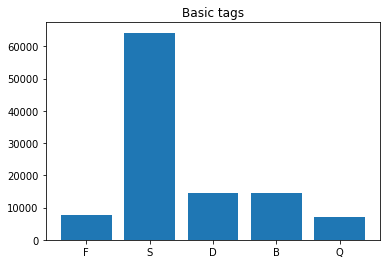

In [25]:
plt.title("Basic tags")
plt.bar(c.keys(), c.values())
plt.show()

In [26]:
c = Counter(df["general_DA_tag"])
c

Counter({'fg': 3092,
         'fh': 8362,
         's': 69873,
         'b': 15167,
         '%': 3103,
         'qy': 4986,
         'qw': 1707,
         'qrr': 392,
         'h': 792,
         'qr': 207,
         'qo': 169,
         'qh': 352})

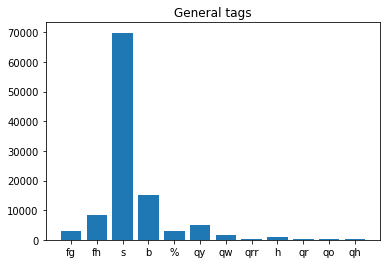

In [27]:
plt.title("General tags")
plt.bar(c.keys(), c.values())
plt.show()

In [28]:
c = Counter(df["full_DA_tag"])
c

Counter({'fg': 3092,
         'fh': 8362,
         'rt': 3101,
         's': 33472,
         'e': 3200,
         'b': 15013,
         'bk': 7177,
         '%': 3103,
         'df': 3724,
         'aa': 5898,
         'd': 1805,
         'na': 1112,
         't1': 198,
         'no': 828,
         'bu': 2091,
         'cs': 2662,
         'aap': 219,
         'ba': 2216,
         'qw': 951,
         'ng': 351,
         'nd': 483,
         'ar': 908,
         'bsc': 150,
         'co': 674,
         'qy': 669,
         'm': 293,
         'qrr': 345,
         '2': 841,
         'h': 792,
         'cc': 371,
         'bs': 141,
         'tc': 212,
         'j': 463,
         'r': 208,
         'bh': 154,
         'bd': 387,
         't3': 165,
         'fa': 259,
         'fe': 307,
         'arp': 150,
         'ft': 119,
         'f': 128,
         't': 253,
         'br': 236,
         'qh': 214,
         'am': 349,
         'g': 87,
         'qr': 127,
         'bc': 51,
         'by':

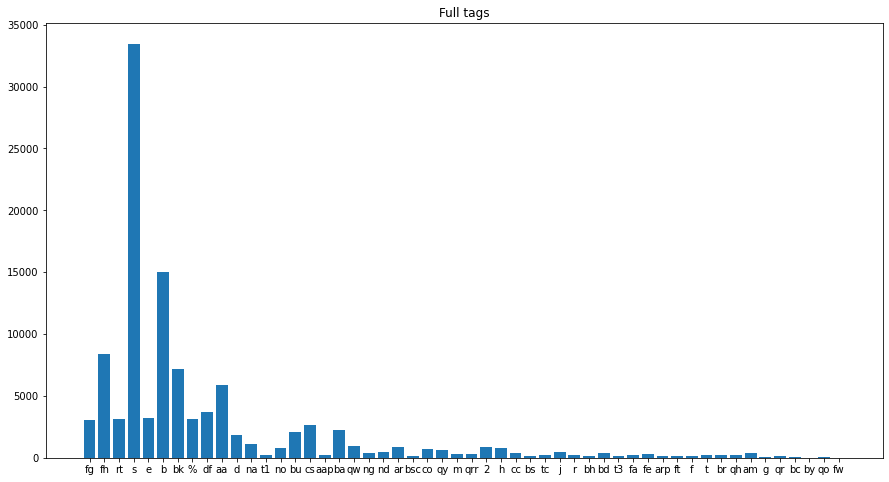

In [32]:
plt.figure(figsize=(15,8))
plt.title("Full tags")
plt.bar(c.keys(), c.values())
plt.show()

# SWDA

In [37]:
direct = "/content/drive/MyDrive/Colab Notebooks/"
with tarfile.open(direct + "swb1_dialogact_annot.tar.gz") as f:
    f.extractall(direct + "swb1_dialogact_annot")

In [38]:
direct += "swb1_dialogact_annot/"

In [41]:
folders = os.listdir(direct)
folders.remove("README")
folders.remove("doc")
folders

['sw00utt',
 'sw01utt',
 'sw02utt',
 'sw03utt',
 'sw04utt',
 'sw05utt',
 'sw06utt',
 'sw07utt',
 'sw08utt',
 'sw09utt',
 'sw10utt',
 'sw11utt',
 'sw12utt',
 'sw13utt']

Каждый диалог находится в отдельном файле, файлы сгруппированы по папкам. Помимо этого, в каждом файле есть предисловие на 33 строчки.

In [56]:
files = list()
dialogs = dict()
num_of_dialogs = 0
for i in range(len(folders)):
    files = os.listdir(direct + folders[i])
    if ("words" in files):
        files.remove("words")
    if ("\x7f" in files):
        files.remove("\x7f")
    num_of_dialogs += len(files)
    dialogs[folders[i]] = files
print("Общее количество диалогов: {}".format(num_of_dialogs))

Общее количество диалогов: 1155


In [91]:
with open(direct + list(dialogs.keys())[0] + '/' + dialogs[list(dialogs.keys())[0]][0], 'r') as f:
    for line in f.readlines()[:54]:
        print(line.rstrip())

*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*
*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*
*x*                                                                     *x*
*x*            Copyright (C) 1995 University of Pennsylvania            *x*
*x*                                                                     *x*
*x*    The data in this file are part of a preliminary version of the   *x*
*x*    Penn Treebank Corpus and should not be redistributed.  Any       *x*
*x*    research using this corpus or based on it should acknowledge     *x*
*x*    that fact, as well as the preliminary nature of the corpus.      *x*
*x*                                                                     *x*
*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*
*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*x*


FILENAME:	4325_1632_1519
TOPIC#:		323
DATE:		920323
TRANSCRIBER:	glp
UTT_CODER:	tc
DIF

Данные можно попробовать добыть следующим способом:

In [99]:
current_dialog_path = ''
current_line = ''
temp = []
for i in dialogs.keys():
    for j in dialogs[i]:
        current_dialog_path = direct + i + '/' + j
        with open(current_dialog_path, 'r') as f:
            for line in f.readlines()[33:54]:
                current_line = line.rstrip()
                if (len(current_line) == 0):
                    continue
                print("tag:", end = '\t\t\t\t')
                print(re.findall("^\S+", current_line)[0])
                temp = re.findall("[A-Z]\.\d+", current_line)[0].split('.')
                print("speaker:", end = '\t\t\t')
                print(temp[0])
                print("total_utterance_number:", end = '\t\t')
                print(temp[1])
                print("persons_utterance:", end = '\t\t')
                print(re.findall("utt\d+", current_line)[0], end = '\n')
                print("utterance:", end = '\t\t\t')
                print(re.sub("^\S+\s*[A-Z]\.\d+\s*utt\d+:\s*", '', current_line), end = '\n\n')
        break
    break

tag:				o
speaker:			A
total_utterance_number:		1
persons_utterance:		utt1
utterance:			Okay.  /

tag:				qw
speaker:			A
total_utterance_number:		1
persons_utterance:		utt2
utterance:			{D So, }

tag:				qy^d
speaker:			B
total_utterance_number:		2
persons_utterance:		utt1
utterance:			[ [ I guess, +

tag:				+
speaker:			A
total_utterance_number:		3
persons_utterance:		utt1
utterance:			What kind of experience [ do you, + do you ] have, then with child care? /

tag:				+
speaker:			B
total_utterance_number:		4
persons_utterance:		utt1
utterance:			I think, ] + {F uh, } I wonder ] if that worked. /

tag:				qy
speaker:			A
total_utterance_number:		5
persons_utterance:		utt1
utterance:			Does it say something? /

tag:				sd
speaker:			B
total_utterance_number:		6
persons_utterance:		utt1
utterance:			I think it usually does.  /

tag:				ad
speaker:			B
total_utterance_number:		6
persons_utterance:		utt2
utterance:			You might try, {F uh, }  /

tag:				h
speaker:			B
total_utterance_num

In [ ]:
columns = ["tag", "speaker", "total_utt_num", "personal_utt_num", "utterance"]

Однако мне не очень понятно, стоит ли оно того. Несмотря на то, что тексты диалогов в общем и целом не содержат информации о какой-то узкой области, которую было бы трудно переводить, в них очень много служебных слов и символов по типу *{F uh, }*, и не очевидно, что с ними делать при переводе на русский язык.

Осталось вычислить среднюю длину диалога:

In [121]:
current_dialog_path = ''
current_line = ''
total_dialogs = 0
total_utterances = 0
current_utt = ''
current_tag = ''
tags_distribution = dict()
print

for i in dialogs.keys():
    for j in dialogs[i]:
        current_dialog_path = direct + i + '/' + j
        with open(current_dialog_path, 'r') as f:
            for line in f.readlines()[33:]:
                current_line = line.rstrip()
                if (len(current_line) == 0):
                    continue
                try:
                    current_utt = re.findall("[A-Z]\.\d+", current_line)[0].split('.')[1]
                    current_tag = re.findall("^\S+", current_line)[0]
                except IndexError:
                    continue
                if (current_tag in tags_distribution.keys()):
                    tags_distribution[current_tag] += 1
                else:
                    tags_distribution[current_tag] = 1
        total_utterances += int(current_utt)
        total_dialogs += 1

print("Общее количество диалогов: {}".format(total_dialogs))
print("Общее количество высказываний: {}".format(total_utterances))
print("Средняя длина диалога: {}".format(total_utterances / total_dialogs))

Общее количество диалогов: 1155
Общее количество высказываний: 125877
Средняя длина диалога: 108.98441558441559


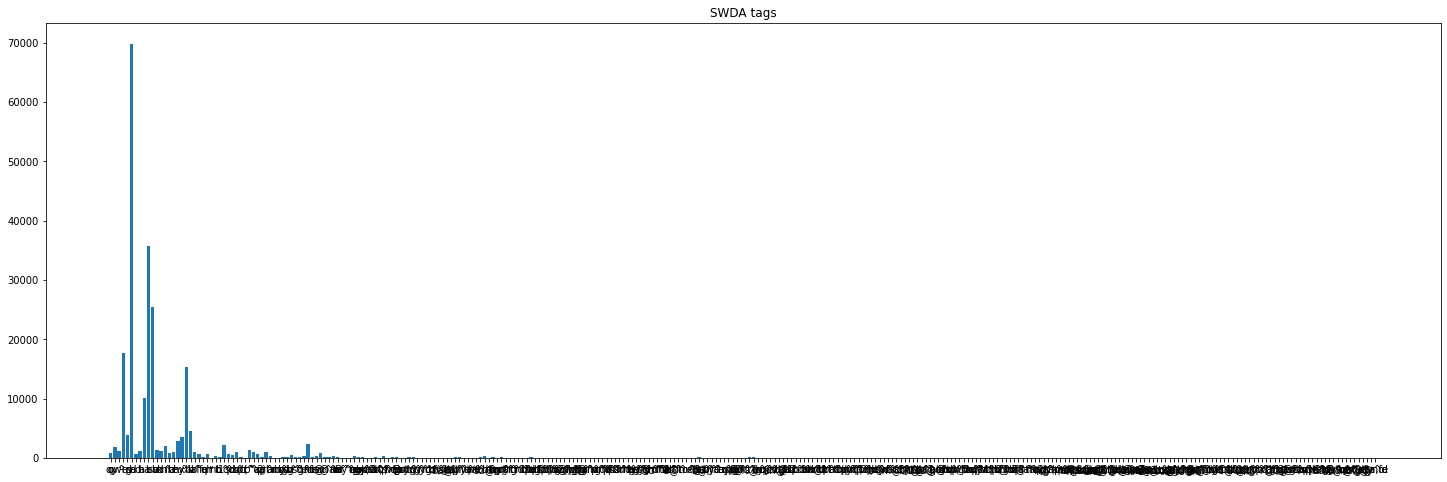

In [126]:
plt.figure(figsize=(25,8))
plt.title("SWDA tags")
plt.bar(tags_distribution.keys(), tags_distribution.values())
plt.show()